In [1]:
%matplotlib inline

import sys
sys.path.append('../src/')

import warnings
warnings.filterwarnings('ignore')

import torch
import wider_dataset
import choke_point_dataset

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from benchmark.models import Detector
from benchmark.core import TsvHandle, run_detection, run_detection_video
from benchmark.stats import calc_precision_recall, calc_ap

# https://github.com/timesler/facenet-pytorch/
from facenet_pytorch import MTCNN

# MTCNN Image detection

In [2]:
train, test, validation = tfds.load('wider_dataset', split=['train', 'test', 'validation'])
data = validation

In [3]:
class MtcnnDetector(Detector):
    def __init__(self):
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print('Running on device: {}'.format(device))
        
        self.detector = MTCNN(margin=14,
                            factor=0.6,
                            keep_all=True,
                            device=device)
    
    def detect(self, image):
        boxes, confidence = self.detector.detect(image)
        return boxes, confidence
    
mtcnn = MtcnnDetector()

Running on device: cpu


In [4]:
with TsvHandle('mtcnn') as tsv:
    path, ap_path, load_path, meta_path = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = mtcnn
    )

print("")
print(path)
print(ap_path)
print(load_path)
print(meta_path)

Running detection
[====================] 100% [3226/3226]
./results/mtcnn-20220615-183635.tsv
./results/mtcnn-20220615-183635-ap.tsv
./results/mtcnn-20220615-183635-load.tsv
./results/mtcnn-20220615-183635-metadata.tsv


In [5]:
with TsvHandle('mtcnn_filtered') as tsv:
    path_filtered, ap_path_filtered, load_path_filtered, meta_path_filtered = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = mtcnn,
        filter_area = 2000
    )

print("")
print(path_filtered)
print(ap_path_filtered)
print(load_path_filtered)
print(meta_path_filtered)

Running detection
[====================] 100% [3226/3226]
./results/mtcnn_filtered-20220615-185132.tsv
./results/mtcnn_filtered-20220615-185132-ap.tsv
./results/mtcnn_filtered-20220615-185132-load.tsv
./results/mtcnn_filtered-20220615-185132-metadata.tsv


# Results

In [6]:
df = pd.read_csv(path, sep='\t', header=0, parse_dates=["Timestamp"])
df_filtered = pd.read_csv(path_filtered, sep='\t', header=0, parse_dates=["Timestamp"])

df_ap = pd.read_csv(ap_path, sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_ap_filtered = pd.read_csv(ap_path_filtered, sep='\t', header=0)
df_ap_filtered = df_ap_filtered.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_load = pd.read_csv(load_path, sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv(meta_path, sep='\t', header=0)

In [7]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [8]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-06-15 18:36:35.381970,0.8,6304485376
1,2022-06-15 18:36:50.530163,41.7,5648945152
2,2022-06-15 18:37:01.714163,53.7,5634035712
3,2022-06-15 18:37:12.833163,53.4,5617115136
4,2022-06-15 18:37:23.872665,53.8,5627043840
...,...,...,...
74,2022-06-15 18:50:26.691162,52.3,5764956160
75,2022-06-15 18:50:37.729163,56.3,5786152960
76,2022-06-15 18:50:49.104664,64.2,5563666432
77,2022-06-15 18:51:00.164665,61.4,5575041024


In [9]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

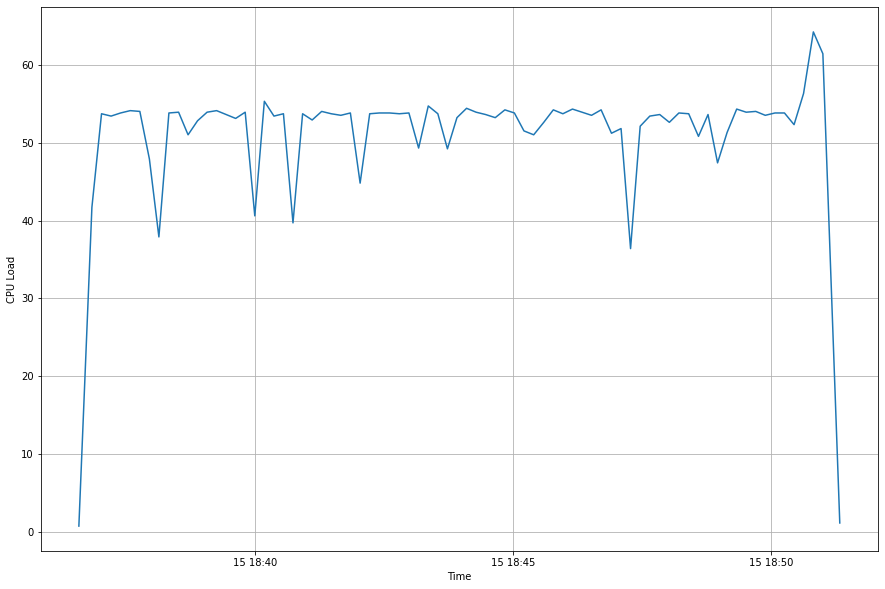

In [10]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

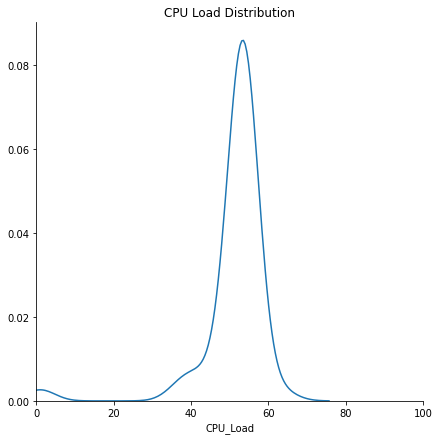

In [11]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

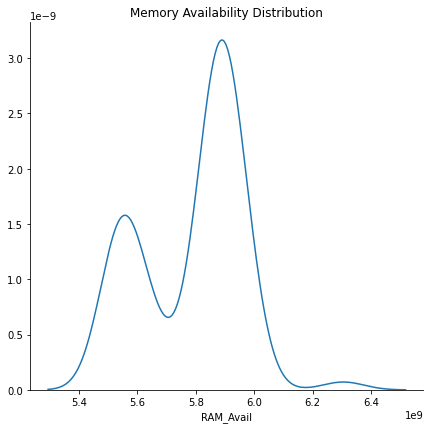

In [12]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [13]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-06-15 18:36:36.254162,315153600,1.000000,1.000000,1.000000,"[0.8915242805755396, 0.8778703002775675, 0.771...",8,0,0,8,"[(176.0, 141.0, 255.0, 245.0), (785.0, 190.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-06-15 18:36:36.484665,225879700,0.000000,0.000000,0.000000,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-06-15 18:36:36.661163,169552400,1.000000,1.000000,1.000000,"[0.8058647841433614, 0.8445652173913043]",2,0,0,2,"[(551.0, 117.0, 604.0, 174.0), (459.0, 48.0, 4...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-06-15 18:36:36.989163,215692700,1.000000,0.112903,0.202899,"[0.8086548488008342, 0.7382198952879581, 0.830...",7,0,55,62,"[(61.0, 494.0, 99.0, 541.0), (254.0, 496.0, 29...","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-06-15 18:36:37.249663,241340600,1.000000,1.000000,1.000000,"[0.8859470468431772, 0.8551800965466023, 0.807...",8,0,0,8,"[(268.0, 70.0, 317.0, 128.0), (410.0, 89.0, 45...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-06-15 18:51:08.709163,297701700,1.000000,1.000000,1.000000,[0.7898197662903546],1,0,0,1,"[(457.0, 159.0, 584.0, 316.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-06-15 18:51:09.087663,371977100,1.000000,1.000000,1.000000,"[0.767156406918356, 0.7021690767519466]",2,0,0,2,"[(715.0, 421.0, 797.0, 531.0), (331.0, 415.0, ...","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-06-15 18:51:09.452665,287836500,0.964286,1.000000,0.981818,"[0.8267477203647416, 0.875, 0.8185483870967742...",27,1,0,27,"[(736.0, 501.0, 768.0, 540.0), (521.0, 479.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-06-15 18:51:09.604166,135082200,1.000000,0.857143,0.923077,"[0.8199643493761141, 0.7321225879682179, 0.959...",6,0,1,7,"[(855.0, 82.0, 901.0, 142.0), (113.0, 109.0, 1...","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [14]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,2.348025e+08,0.843193,0.708481,0.729555,4.957843,0.331680,7.350899,12.308741
std,1.135378e+08,0.307769,0.362421,0.330006,11.012020,0.706361,33.736980,39.822258
min,6.845410e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.603093e+08,0.857143,0.439737,0.571429,1.000000,0.000000,0.000000,1.000000
50%,2.123824e+08,1.000000,1.000000,0.857143,2.000000,0.000000,0.000000,3.000000
75%,2.787660e+08,1.000000,1.000000,1.000000,5.000000,0.000000,3.000000,9.000000
max,1.718102e+09,1.000000,1.000000,1.000000,267.000000,8.000000,622.000000,709.000000


In [15]:
speed = df['Speed'].div(1e6).round(2)
speed.describe()

count    3226.000000
mean      234.802517
std       113.537762
min        68.450000
25%       160.310000
50%       212.380000
75%       278.767500
max      1718.100000
Name: Speed, dtype: float64

### Generate Precision/Recall columns

In [16]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()
df_ap = calc_precision_recall(df_ap, all_gts)

df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,1.000000,True,True,True,1.000000,0.000025,1.000000,0.000025,1.000000,0.000025
1,1.000000,True,True,False,1.000000,0.000050,1.000000,0.000050,0.500000,0.000025
2,1.000000,True,True,True,1.000000,0.000076,1.000000,0.000076,0.666667,0.000050
3,1.000000,True,True,True,1.000000,0.000101,1.000000,0.000101,0.750000,0.000076
4,1.000000,True,True,False,1.000000,0.000126,1.000000,0.000126,0.600000,0.000076
...,...,...,...,...,...,...,...,...,...,...
17059,0.700543,False,False,False,0.939097,0.403470,0.913130,0.392314,0.620633,0.266647
17060,0.700464,True,True,False,0.939101,0.403496,0.913135,0.392339,0.620597,0.266647
17061,0.700239,True,True,True,0.939104,0.403521,0.913140,0.392364,0.620619,0.266672
17062,0.700187,True,True,False,0.939108,0.403546,0.913145,0.392389,0.620583,0.266672


In [17]:
all_gts_filtered = df_filtered['Positives'].sum() + df_filtered['Negatives'].sum()
df_ap_filtered = calc_precision_recall(df_ap_filtered, all_gts_filtered)

df_ap_filtered

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,1.000000,True,True,True,1.000000,0.000140,1.000000,0.000140,1.000000,0.000140
1,1.000000,True,True,True,1.000000,0.000281,1.000000,0.000281,1.000000,0.000281
2,1.000000,True,True,False,1.000000,0.000421,1.000000,0.000421,0.666667,0.000281
3,1.000000,True,True,True,1.000000,0.000561,1.000000,0.000561,0.750000,0.000421
4,1.000000,True,True,True,1.000000,0.000702,1.000000,0.000702,0.800000,0.000561
...,...,...,...,...,...,...,...,...,...,...
6376,0.701781,False,False,False,0.930218,0.832445,0.907950,0.812518,0.710365,0.635700
6377,0.701700,False,False,False,0.930072,0.832445,0.907808,0.812518,0.710254,0.635700
6378,0.701296,False,False,False,0.929926,0.832445,0.907666,0.812518,0.710143,0.635700
6379,0.700917,False,False,False,0.929781,0.832445,0.907524,0.812518,0.710031,0.635700


In [18]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_data.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_data.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_data.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

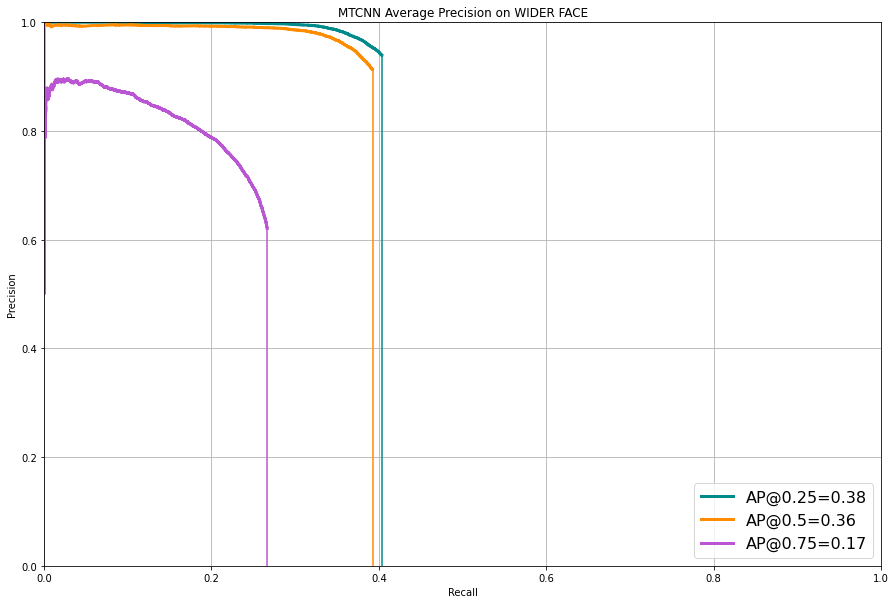

In [19]:
plot_pr(df_ap, 'MTCNN Average Precision on WIDER FACE')

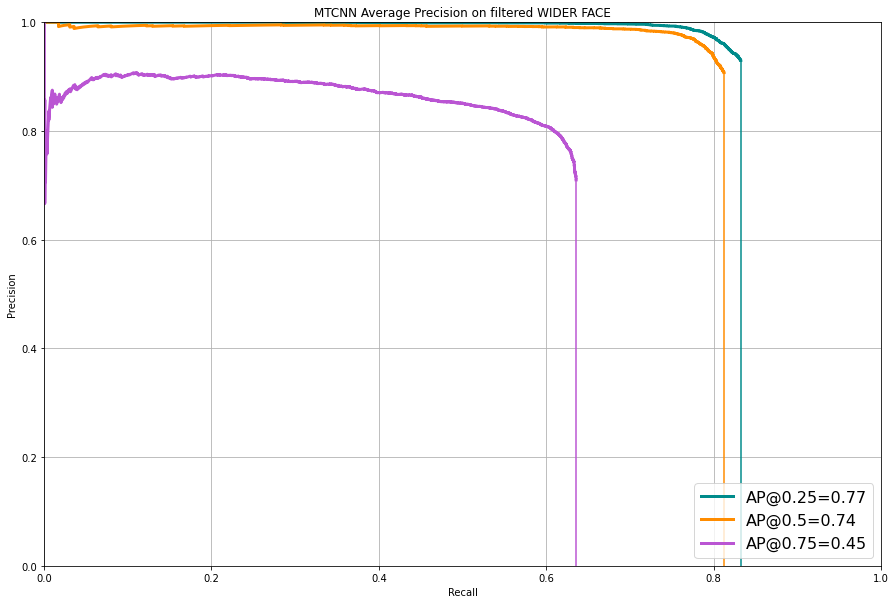

In [20]:
plot_pr(df_ap_filtered, 'MTCNN Average Precision on filtered WIDER FACE')

# MTCNN Video detection

In [21]:
test = tfds.load('choke_point', split=['test'])

In [22]:
data = test[0]

In [23]:
class MtcnnDetector(Detector):
    def __init__(self):
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print('Running on device: {}'.format(device))
        
        self.detector = MTCNN(margin=14,
                            factor=0.6,
                            keep_all=True,
                            device=device)
    
    def detect(self, image):
        boxes, confidence = self.detector.detect(image)
        return boxes, confidence
    
mtcnn = MtcnnDetector()

Running on device: cpu


In [24]:
stt_ious, detection_percentages, mean_confidences, mean_inference_times = run_detection_video(
    samples=data, 
    detector=mtcnn,
    results_folder="mtcnn",
    save_videos=True
)

Frames: [====================] 100% [164/164], Videos: [216/216]

In [25]:
print("Mean Video STT-IOU: {0:.2f}".format(np.mean(stt_ious)))
print("Mean detection percentage of faces in all videos: {:.2f}".format(np.mean(detection_percentages)))
print("Mean confidence of boxes in all videos: {:.2f}".format(np.mean(mean_confidences)))
print("Mean inference time for all frames: {:.2f}ms".format(np.mean(mean_inference_times) / 1e+6))

Mean Video STT-IOU: 0.69
Mean detection percentage of faces in all videos: 98.17
Mean confidence of boxes in all videos: 1.00
Mean inference time for all frames: 80.02ms
